In [1]:
from PIL import Image
import numpy as np
import glob
import cv2 as cv
import os
import numpy as np
import sklearn as sk #general imports, initial data preprocessing/OS stuff
import os
import torch as T
import torch.nn as nn
import torch.optim as optim #Neural network imports, multiply data etc
from torchvision.transforms import ToTensor
import torchvision.models as models
import torchvision
import torch.nn.functional as F #Neural Network used in Comp4660 at ANU
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from pathlib import Path
from torchvision.datasets import ImageFolder
from sklearn.preprocessing import MinMaxScaler #normalize data
from sklearn.metrics import confusion_matrix #analysis
from torchvision import transforms
from random import shuffle
import itertools
from torch.optim.lr_scheduler import _LRScheduler

C:\Users\campb\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\campb\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
### - GLOBALS - ###

DPS = '/Users/campb/Documents/Comp4528/CLab-2/Dataset' #Change for marking my computer just isnt great with paths as im on windows

folds = 3 #Have to do 3-fold since my computer cannot handle anything else

device = T.device('cuda:0' if (T.cuda.is_available())  else 'cpu') #Train on device, no parallel gpu

In [3]:
train_ims = np.load('/Users/campb/Documents/Comp4528/CLab-2/Dataset/kmnist-train-imgs.npz')['arr_0']
test_ims = np.load('/Users/campb/Documents/Comp4528/CLab-2/Dataset/kmnist-test-imgs.npz')['arr_0']
train_lab = np.load('/Users/campb/Documents/Comp4528/CLab-2/Dataset/kmnist-train-labels.npz')['arr_0']
test_lab = np.load('/Users/campb/Documents/Comp4528/CLab-2/Dataset/kmnist-test-labels.npz')['arr_0']
val_ims = np.load('/Users/campb/Documents/Comp4528/CLab-2/Dataset/kmnist-val-imgs.npz')['arr_0']
val_lab = np.load('/Users/campb/Documents/Comp4528/CLab-2/Dataset/kmnist-val-labels.npz')['arr_0']

In [4]:
print(train_ims.shape, train_lab.shape, test_ims.shape, test_lab.shape, val_ims.shape, val_lab.shape)

(59000, 28, 28) (59000,) (10000, 28, 28) (10000,) (1000, 28, 28) (1000,)


In [5]:
#Import as tensors
train = T.from_numpy(np.float32(np.concatenate([train_ims,test_ims]))).to(device)
labs = T.from_numpy(np.float32(np.concatenate([train_lab,test_lab]))).to(device)
assert(train.shape[0] == labs.shape[0])
val_ims = T.from_numpy(np.float32(val_ims)).to(device)
val_lab = T.from_numpy(np.float32(val_lab)).to(device)

In [6]:
#Data augmentation
transform = transforms.Compose([
            transforms.Normalize((0.), (1.0)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomCrop(28, 4) #Random crop image with output size 28 and padding set to 4, default padding is 0 padding
            ])

In [7]:
train = transform(train) #apply transform to train images

In [8]:
val_ims = transform(val_ims) #apply transform to validation images

In [9]:
print(train.shape, labs.shape, val_ims.shape, val_lab.shape)

### - Model Variables - ###
lr = 1e-3
bs = (0.9, 0.999)

LabNet= nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
    nn.ReLU(), #First layer
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(), #Second layer
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(7*7*64, 1024), #Filter size 64, and we downsample 2x twice so 28/4
    nn.ReLU(),
    nn.Linear(1024,10)
).to(device)
print(LabNet)

torch.Size([69000, 28, 28]) torch.Size([69000]) torch.Size([1000, 28, 28]) torch.Size([1000])
Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=3136, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=10, bias=True)
)


In [10]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(LabNet.parameters(), lr = lr, betas=bs)

In [11]:
epochs = 10

#Loss and Accuracy Methods Only need train
all_tloss_e = []
all_tacc_e = []

test_losses = []
test_accuracy = []

#Setup k-Fold
d = list(range(train.shape[0]))
shuffle(d) #Data is shuffled
d = np.array_split(d, folds)

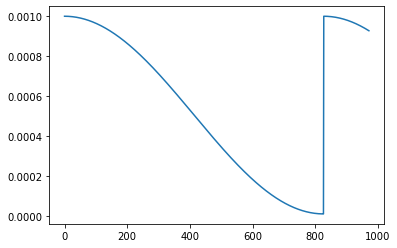

In [12]:
#Cyclic Learning Rate Scheduler
#Cyclic LR Scheduler
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

sched = CyclicLR(optimizer, cosine(t_max=(620-(620/3)) * 2, eta_min=lr/100)) #Cycled around about 1/10th of the lr

scheduled = cosine(t_max=(620-(620/3)) * 2, eta_min=lr/100)
learning_rates = [scheduled(t, .001) for t in range(int((304-(304/5))) * 4)]
plt.plot(learning_rates)

In [13]:
### - train cell - ###
for epoch in range(epochs):
    fold_acc = []
    
    fold_loss = []
    for i in range(folds-1):
        print("Current Fold: " + str(i))
        correct_train = 0
        total_train = 0 #Add mean accuracy of folds
        test = train[d[-i]]
        t_lab = labs[d[-i]]
        train_i = d[:i] + d[i+1:]
        train_set = train[list(itertools.chain.from_iterable(train_i))]
        train_lab = labs[list(itertools.chain.from_iterable(train_i))]
        
        output_train = []
        
        correct = 0
        
        for i, im in enumerate(train_set):
            if 1 % 100 == 0:
                print("100 images")
            outs = LabNet(im[None,:].unsqueeze(1)) #forward pass
            loss_i = loss(outs, train_lab[i].unsqueeze(-1).long())
            
            fold_loss.append(loss_i.item()) #append losses to graph
            
            output_train.append(outs)
            
            LabNet.zero_grad(set_to_none=True) # Reset Grads
            
            loss_i.backward()
            
            optimizer.step() #update weights
            
            sched.step() #Step through LR Scheduler
            
            #check if correct
            guess = T.argmax(outs).item()
            if guess == train_lab[i].item():
                correct_train += 1
            total_train += 1
        fold_acc.append(correct_train/total_train)
        
    #Fold level metrics
    #Train set accuracy and loss
    all_tloss_e.append(np.mean(fold_loss)) #Add mean loss over all folds
    all_tacc_e.append(np.mean(fold_acc)) #Add mean fold accuracy to accuracy metric
    
    #Test-set accuracy
    test_total = 0
    test_correct = 0
    
    test_loss = []
    
    for j, y in enumerate(test):
        tout = LabNet(y[None,:].unsqueeze(1))
        
        test_loss.append(loss(tout, t_lab[j].unsqueeze(-1).long()).item())
        guess1 = T.argmax(tout).item()
        if guess1 == t_lab[j].item():
            test_correct += 1
        test_total += 1
        
    test_accuracy.append(test_correct/test_total)
    test_losses.append(np.mean(test_loss))
    
    if epoch % 1 == 0:
        # convert three-column predicted Y values to one column for 

        print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
                % (epoch + 1, epochs, np.mean(fold_loss), np.mean(fold_acc)*100))
        print('Testing Loss: %.4f  TestingAccuracy: %.2f %%'
                % (np.mean(test_loss), (test_correct/test_total)*100))

Current Fold: 0
Current Fold: 1
Epoch [1/10] Loss: 0.4114  Accuracy: 88.76 %
Testing Loss: 0.3031  TestingAccuracy: 92.71 %
Current Fold: 0
Current Fold: 1
Epoch [2/10] Loss: 0.2918  Accuracy: 92.82 %
Testing Loss: 0.2821  TestingAccuracy: 93.10 %
Current Fold: 0
Current Fold: 1
Epoch [3/10] Loss: 0.2892  Accuracy: 92.92 %
Testing Loss: 0.2476  TestingAccuracy: 95.25 %
Current Fold: 0
Current Fold: 1
Epoch [4/10] Loss: 0.2852  Accuracy: 92.90 %
Testing Loss: 0.1618  TestingAccuracy: 95.20 %
Current Fold: 0
Current Fold: 1
Epoch [5/10] Loss: 0.2627  Accuracy: 93.71 %
Testing Loss: 0.1662  TestingAccuracy: 96.03 %
Current Fold: 0
Current Fold: 1
Epoch [6/10] Loss: 0.2360  Accuracy: 93.94 %
Testing Loss: 0.1696  TestingAccuracy: 95.77 %
Current Fold: 0
Current Fold: 1
Epoch [7/10] Loss: 0.2181  Accuracy: 94.09 %
Testing Loss: 0.1415  TestingAccuracy: 96.37 %
Current Fold: 0
Current Fold: 1
Epoch [8/10] Loss: 0.2118  Accuracy: 94.20 %
Testing Loss: 0.1625  TestingAccuracy: 95.80 %
Current 

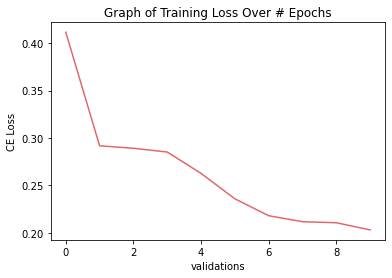

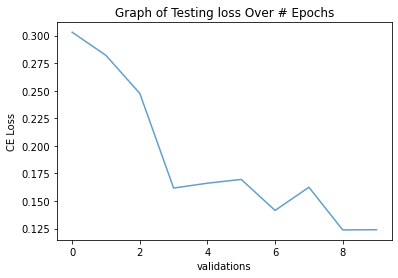

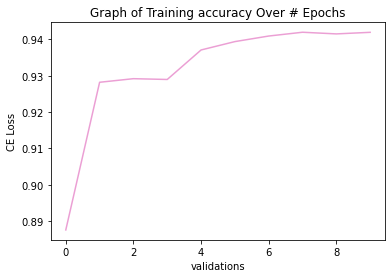

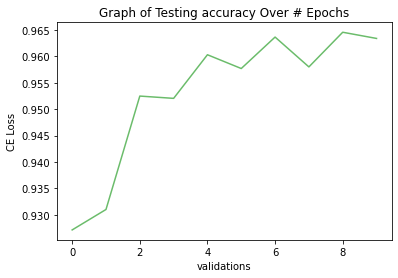

In [14]:
#Graph of loss over time(Num Epochs)
#training loss
plt.plot(range(0,(epochs)), all_tloss_e, alpha=0.7, color='tab:red')
plt.xlabel('validations')
plt.ylabel('CE Loss')
plt.title('Graph of Training Loss Over # Epochs')
plt.show()
#test loss
plt.plot(range(0,(epochs)), test_losses, alpha=0.7, color='tab:blue')
plt.xlabel('validations')
plt.ylabel('CE Loss')
plt.title('Graph of Testing loss Over # Epochs')
plt.show()
#training acc
plt.plot(range(0,(epochs)), all_tacc_e, alpha=0.7, color='tab:pink')
plt.xlabel('validations')
plt.ylabel('CE Loss')
plt.title('Graph of Training accuracy Over # Epochs')
plt.show()
#testing acc
plt.plot(range(0,(epochs)), test_accuracy, alpha=0.7, color='tab:green')
plt.xlabel('validations')
plt.ylabel('CE Loss')
plt.title('Graph of Testing accuracy Over # Epochs')
plt.show()

100.0


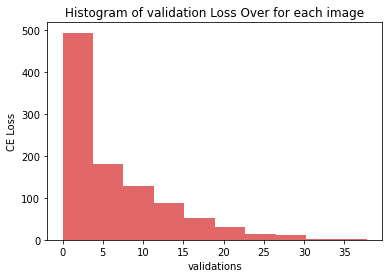

Accuracy: 31.7%


In [15]:
#Handle validation set
val_loss = []
val_acc = []
val_correct = 0
val_total = 0

for k, y in enumerate(val_ims):
    tout = LabNet(y[None,:].unsqueeze(1))

    val_loss.append(loss(tout, val_lab[k].unsqueeze(-1).long()).item())
    guess1 = T.argmax(tout).item()
    if guess1 == val_lab[k].item():
        val_correct += 1
    val_total += 1
print(len(val_loss)/10)
plt.hist(val_loss, int(len(val_loss)/100), alpha=0.7, color='tab:red')
plt.xlabel('validations')
plt.ylabel('CE Loss')
plt.title('Histogram of validation Loss Over for each image')
plt.show()

print("Accuracy: " + str((val_correct/val_total)*100) + "%")